# Neural Network for CAP Classification
### Author: Apurva R Umredkar


In [1]:
#Libraries
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.utils import *

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import time
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset = loadmat("/content/drive/MyDrive/CAP Research Data/eeg _signals_1d_balanced_9306.mat")['val']
#dataset= np.load("/content/drive/MyDrive/CAP Research Data/eeg_data_21984_balanced.npy")
N= dataset.shape[0]
mmscaler= MinMaxScaler()

signals= dataset[:,:1024]
signals_dft= np.fft.fft(signals)
dft_abs = np.abs(signals_dft)
dft_ang = np.angle(signals_dft)

inputs = mmscaler.fit_transform(dft_abs[:,1:513]).reshape((N,512,1))
targets= dataset[:,1024]

from sklearn.utils import shuffle
X, Y= shuffle(inputs, targets, random_state= None)

skfold = StratifiedKFold(n_splits=10)

In [3]:
#Architecture of the model
def inception_module(layer, f1, f2, f3, f4):
  conv1 = Conv1D(f1, 1, activation= 'relu', padding= 'same')(layer)
  conv2 = Conv1D(f1, 1, activation= 'relu', padding= 'same')(layer)
  conv3 = Conv1D(f1, 1, activation= 'relu', padding= 'same')(layer)
  maxp = MaxPool1D(pool_size=3, strides= 1, padding= 'same')(layer)

  conv2 = Conv1D(f2, 3, activation= 'relu', padding= 'same')(conv2)
  conv3 = Conv1D(f3, 5, activation= 'relu', padding= 'same')(conv3)
  conv4 = Conv1D(f4, 1, activation= 'relu', padding= 'same')(maxp)

  return Concatenate()([conv1, conv2, conv3, conv4])

input_signal= Input(shape=(512,1))

incept= inception_module(input_signal, 32,64,128,32)
conv= Conv1D(192, 5, activation= 'relu', padding= 'same')(incept)
conv= Conv1D(128, 3, activation= 'relu', padding= 'same')(conv)
gru= GRU(128, return_sequences= True)(conv)

maxp= MaxPool1D()(gru)

incept= inception_module(maxp,16,32,64,16)
conv= Conv1D(96, 5, activation= 'relu', padding= 'same')(incept)
conv= Conv1D(64, 3, activation= 'relu', padding= 'same')(conv)
gru= GRU(64, return_sequences= True)(conv)

maxp= MaxPool1D()(gru)

incept= inception_module(maxp,8,16,32,8)
conv= Conv1D(48, 5, activation= 'relu', padding= 'same')(incept)
conv= Conv1D(32, 3, activation= 'relu', padding= 'same')(conv)
gru= GRU(32, return_sequences= True)(conv)

maxp= MaxPool1D()(gru)

incept= inception_module(maxp,4,8,16,4)
conv= Conv1D(24, 5, activation= 'relu', padding= 'same')(incept)
conv= Conv1D(16, 3, activation= 'relu', padding= 'same')(conv)
gru= GRU(16, return_sequences= True)(conv)

maxp= MaxPool1D()(gru)

incept= inception_module(maxp,2,4,8,2)
conv= Conv1D(12, 5, activation= 'relu', padding= 'same')(incept)
conv= Conv1D(8, 3, activation= 'relu', padding= 'same')(conv)
gru= GRU(8, return_sequences= True)(conv)

flat = Flatten()(gru)
output= Dense(2, activation='softmax')(flat)


if 'model' in globals() or 'model' in locals(): del model

model= keras.Model(inputs = input_signal, outputs = output)
model.summary()
init_weights = model.get_weights()
#plot_model(model, show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 512, 32)      64          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 512, 32)      64          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 512, 1)       0           input_1[0][0]                    
______________________________________________________________________________________________

Training for Fold #1
Epoch 1/2500
105/105 [==============================] - 56s 133ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.4919
Epoch 2/2500
105/105 [==============================] - 10s 94ms/step - loss: 0.6917 - accuracy: 0.5533 - val_loss: 0.6880 - val_accuracy: 0.5182
Epoch 3/2500
105/105 [==============================] - 10s 95ms/step - loss: 0.6635 - accuracy: 0.6333 - val_loss: 0.6730 - val_accuracy: 0.5881
Epoch 4/2500
105/105 [==============================] - 10s 94ms/step - loss: 0.6248 - accuracy: 0.6743 - val_loss: 0.6110 - val_accuracy: 0.6764
Epoch 5/2500
105/105 [==============================] - 10s 94ms/step - loss: 0.6025 - accuracy: 0.6854 - val_loss: 0.5997 - val_accuracy: 0.6681
Epoch 6/2500
105/105 [==============================] - 10s 94ms/step - loss: 0.5903 - accuracy: 0.6964 - val_loss: 0.6067 - val_accuracy: 0.6657
Epoch 7/2500
105/105 [==============================] - 10s 94ms/step - loss: 0.5849 - accuracy: 0.697

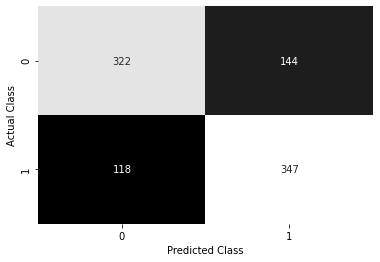

Accuracy Metrics:                 0
count  110.000000
mean     0.731229
std      0.032904
min      0.502090
25%      0.730037
50%      0.737164
75%      0.743545
max      0.759701

Loss Metrics:                 0
count  110.000000
mean     0.540040
std      0.031874
min      0.501605
25%      0.521731
50%      0.535949
75%      0.547263
max      0.693172

Val. Accuracy Metrics:                 0
count  110.000000
mean     0.705449
std      0.031607
min      0.491940
25%      0.705672
50%      0.712239
75%      0.717015
max      0.724776

Val. Loss Metrics:                 0
count  110.000000
mean     0.564838
std      0.022765
min      0.549136
25%      0.555437
50%      0.558474
75%      0.564322
max      0.693196


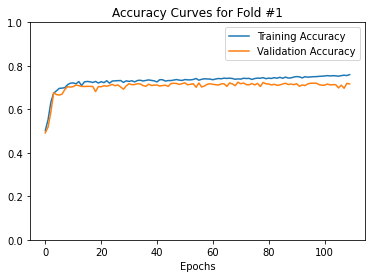

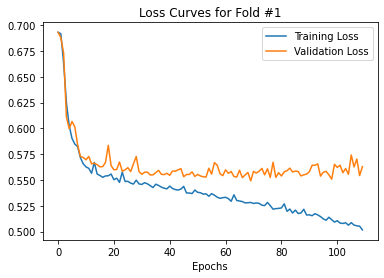

Training for Fold #2
Epoch 1/2500
105/105 [==============================] - 20s 112ms/step - loss: 0.6932 - accuracy: 0.4924 - val_loss: 0.6932 - val_accuracy: 0.4919
Epoch 2/2500
105/105 [==============================] - 10s 97ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.4919
Epoch 3/2500
105/105 [==============================] - 10s 96ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.4919
Epoch 4/2500
105/105 [==============================] - 10s 96ms/step - loss: 0.6931 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.4919
Epoch 5/2500
105/105 [==============================] - 10s 95ms/step - loss: 0.6929 - accuracy: 0.5021 - val_loss: 0.6923 - val_accuracy: 0.4919
Epoch 6/2500
105/105 [==============================] - 10s 94ms/step - loss: 0.6906 - accuracy: 0.5287 - val_loss: 0.6888 - val_accuracy: 0.5200
Epoch 7/2500
105/105 [==============================] - 10s 94ms/step - loss: 0.6831 - accuracy: 0.590

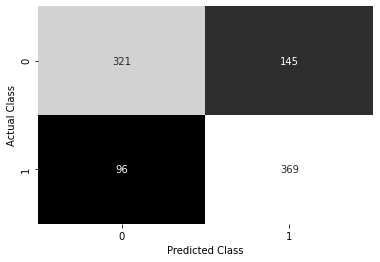

Accuracy Metrics:                 0
count  118.000000
mean     0.711178
std      0.058250
min      0.492388
25%      0.710896
50%      0.729851
75%      0.742052
max      0.758806

Loss Metrics:                 0
count  118.000000
mean     0.557440
std      0.049741
min      0.503176
25%      0.523394
50%      0.542513
75%      0.568766
max      0.693160

Val. Accuracy Metrics:                 0
count  118.000000
mean     0.692456
std      0.051839
min      0.491940
25%      0.696269
50%      0.708060
75%      0.717463
max      0.729552

Val. Loss Metrics:                 0
count  118.000000
mean     0.573421
std      0.040036
min      0.543105
25%      0.550022
50%      0.557229
75%      0.576334
max      0.693175


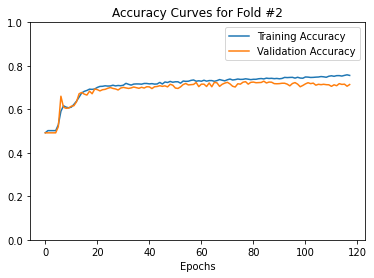

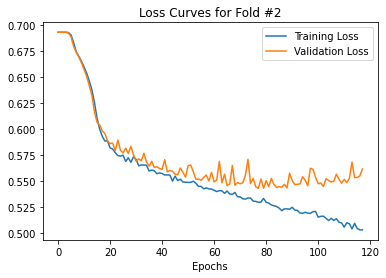

Training for Fold #3
Epoch 1/2500
105/105 [==============================] - 19s 110ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.4919
Epoch 2/2500
105/105 [==============================] - 10s 96ms/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.4919
Epoch 3/2500
105/105 [==============================] - 10s 97ms/step - loss: 0.6931 - accuracy: 0.5021 - val_loss: 0.6932 - val_accuracy: 0.4919
Epoch 4/2500
105/105 [==============================] - 10s 96ms/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6932 - val_accuracy: 0.4919
Epoch 5/2500
105/105 [==============================] - 10s 96ms/step - loss: 0.6931 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.4919
Epoch 6/2500
105/105 [==============================] - 10s 95ms/step - loss: 0.6930 - accuracy: 0.5021 - val_loss: 0.6930 - val_accuracy: 0.4919
Epoch 7/2500
105/105 [==============================] - 10s 95ms/step - loss: 0.6926 - accuracy: 0.502

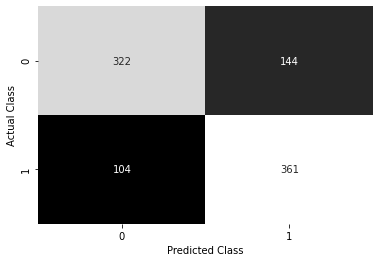

Accuracy Metrics:                 0
count  111.000000
mean     0.708758
std      0.064564
min      0.500149
25%      0.712388
50%      0.729851
75%      0.743806
max      0.760149

Loss Metrics:                 0
count  111.000000
mean     0.560298
std      0.054385
min      0.503285
25%      0.524425
50%      0.542125
75%      0.569413
max      0.693160

Val. Accuracy Metrics:                 0
count  111.000000
mean     0.691671
std      0.057073
min      0.491940
25%      0.700000
50%      0.710448
75%      0.718806
max      0.728358

Val. Loss Metrics:                 0
count  111.000000
mean     0.577518
std      0.043897
min      0.546337
25%      0.551146
50%      0.557396
75%      0.575928
max      0.693183


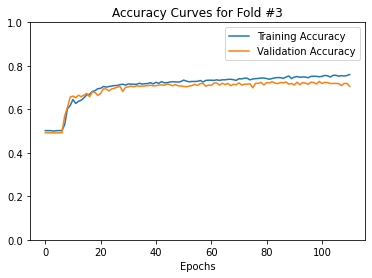

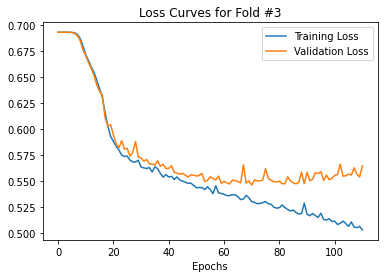

Training for Fold #4
Epoch 1/2500
105/105 [==============================] - 19s 112ms/step - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6931 - val_accuracy: 0.5081
Epoch 2/2500
105/105 [==============================] - 10s 97ms/step - loss: 0.6932 - accuracy: 0.4945 - val_loss: 0.6932 - val_accuracy: 0.4919
Epoch 3/2500
105/105 [==============================] - 10s 97ms/step - loss: 0.6932 - accuracy: 0.4931 - val_loss: 0.6932 - val_accuracy: 0.4919
Epoch 4/2500
105/105 [==============================] - 10s 97ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4919
Epoch 5/2500
105/105 [==============================] - 10s 97ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4919
Epoch 6/2500
105/105 [==============================] - 10s 97ms/step - loss: 0.6931 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4919
Epoch 7/2500
105/105 [==============================] - 10s 96ms/step - loss: 0.6932 - accuracy: 0.501

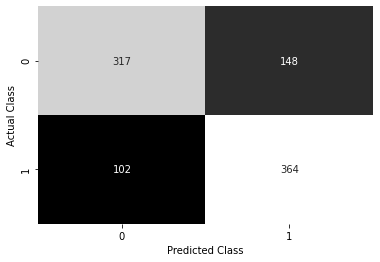

Accuracy Metrics:                 0
count  104.000000
mean     0.674087
std      0.094498
min      0.493134
25%      0.597313
50%      0.726045
75%      0.739627
max      0.752836

Loss Metrics:                 0
count  104.000000
mean     0.581653
std      0.070443
min      0.506959
25%      0.526190
50%      0.543544
75%      0.666593
max      0.693156

Val. Accuracy Metrics:                 0
count  104.000000
mean     0.659776
std      0.088459
min      0.491940
25%      0.601045
50%      0.707463
75%      0.719403
max      0.728358

Val. Loss Metrics:                 0
count  104.000000
mean     0.594948
std      0.060676
min      0.542561
25%      0.549209
50%      0.556813
75%      0.666447
max      0.693187


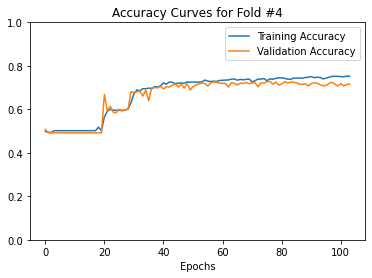

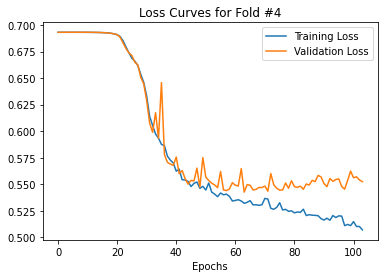

Training for Fold #5
Epoch 1/2500
105/105 [==============================] - 20s 113ms/step - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6931 - val_accuracy: 0.4919
Epoch 2/2500
105/105 [==============================] - 10s 99ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4919
Epoch 3/2500
105/105 [==============================] - 10s 99ms/step - loss: 0.6931 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4919
Epoch 4/2500
105/105 [==============================] - 10s 98ms/step - loss: 0.6931 - accuracy: 0.4988 - val_loss: 0.6932 - val_accuracy: 0.4919
Epoch 5/2500
105/105 [==============================] - 10s 97ms/step - loss: 0.6931 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4919
Epoch 6/2500
105/105 [==============================] - 10s 96ms/step - loss: 0.6931 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4919
Epoch 7/2500
105/105 [==============================] - 10s 96ms/step - loss: 0.6931 - accuracy: 0.501

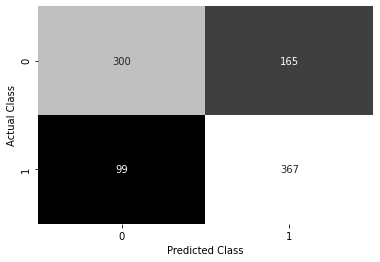

Accuracy Metrics:                0
count  92.000000
mean    0.693456
std     0.079364
min     0.498657
25%     0.696455
50%     0.728955
75%     0.738284
max     0.754478

Loss Metrics:                0
count  92.000000
mean    0.568677
std     0.061541
min     0.508865
25%     0.527792
50%     0.541932
75%     0.583642
max     0.693156

Val. Accuracy Metrics:                0
count  92.000000
mean    0.677359
std     0.074047
min     0.491940
25%     0.687015
50%     0.711940
75%     0.717612
max     0.724776

Val. Loss Metrics:                0
count  92.000000
mean    0.584686
std     0.051142
min     0.547374
25%     0.553338
50%     0.557296
75%     0.590069
max     0.693165


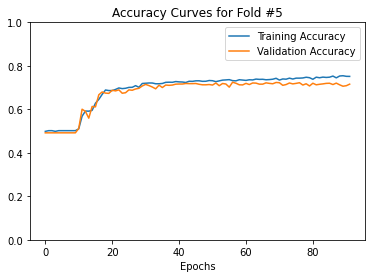

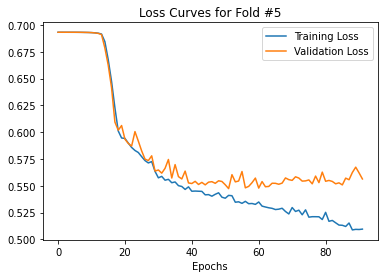

Training for Fold #6
Epoch 1/2500
105/105 [==============================] - 20s 120ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4919
Epoch 2/2500
105/105 [==============================] - 10s 99ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4919
Epoch 3/2500
105/105 [==============================] - 10s 98ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4919
Epoch 4/2500
105/105 [==============================] - 10s 97ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4919
Epoch 5/2500
105/105 [==============================] - 10s 97ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4919
Epoch 6/2500
105/105 [==============================] - 10s 97ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4919
Epoch 7/2500
105/105 [==============================] - 10s 96ms/step - loss: 0.6931 - accuracy: 0.501

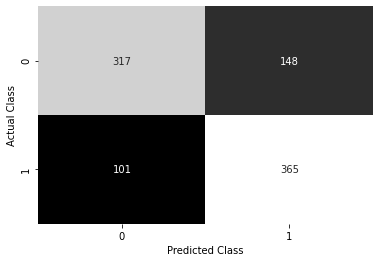

Accuracy Metrics:                 0
count  108.000000
mean     0.696125
std      0.078137
min      0.501940
25%      0.698694
50%      0.727687
75%      0.740485
max      0.762836

Loss Metrics:                 0
count  108.000000
mean     0.565726
std      0.060841
min      0.497746
25%      0.525729
50%      0.542496
75%      0.582552
max      0.693180

Val. Accuracy Metrics:                 0
count  108.000000
mean     0.679619
std      0.073455
min      0.491940
25%      0.681343
50%      0.713433
75%      0.720149
max      0.725970

Val. Loss Metrics:                 0
count  108.000000
mean     0.581246
std      0.050539
min      0.543787
25%      0.550231
50%      0.555976
75%      0.589379
max      0.693208


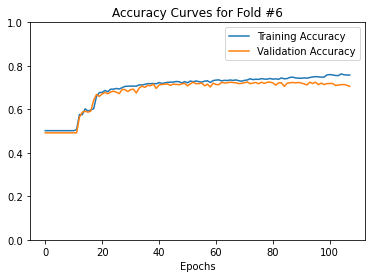

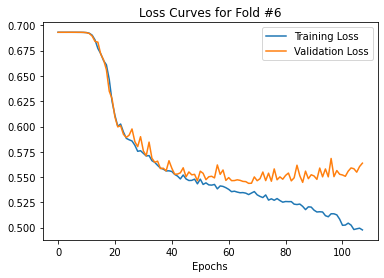

Training for Fold #7
Epoch 1/2500
105/105 [==============================] - 20s 117ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4922
Epoch 2/2500
105/105 [==============================] - 10s 98ms/step - loss: 0.6932 - accuracy: 0.4978 - val_loss: 0.6932 - val_accuracy: 0.4922
Epoch 3/2500
105/105 [==============================] - 10s 98ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4922
Epoch 4/2500
105/105 [==============================] - 10s 98ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4922
Epoch 5/2500
105/105 [==============================] - 10s 98ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4922
Epoch 6/2500
105/105 [==============================] - 10s 97ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4922
Epoch 7/2500
105/105 [==============================] - 10s 97ms/step - loss: 0.6932 - accuracy: 0.501

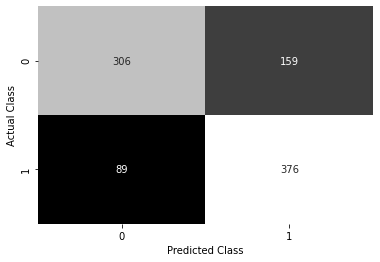

Accuracy Metrics:                 0
count  125.000000
mean     0.684364
std      0.093206
min      0.497761
25%      0.686866
50%      0.727313
75%      0.742836
max      0.767313

Loss Metrics:                 0
count  125.000000
mean     0.570508
std      0.069487
min      0.482256
25%      0.522790
50%      0.542457
75%      0.597678
max      0.693168

Val. Accuracy Metrics:                 0
count  125.000000
mean     0.663084
std      0.085116
min      0.492243
25%      0.677804
50%      0.707041
75%      0.713007
max      0.726730

Val. Loss Metrics:                 0
count  125.000000
mean     0.591680
std      0.054419
min      0.546637
25%      0.554545
50%      0.563959
75%      0.598149
max      0.693211


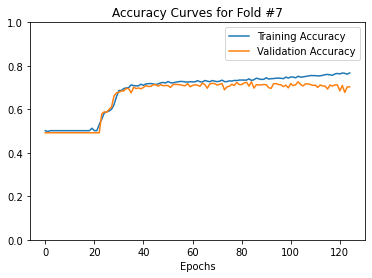

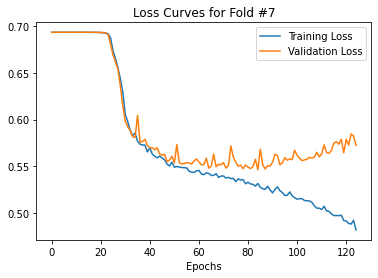

Training for Fold #8
Epoch 1/2500
105/105 [==============================] - 20s 114ms/step - loss: 0.6932 - accuracy: 0.4943 - val_loss: 0.6932 - val_accuracy: 0.4922
Epoch 2/2500
105/105 [==============================] - 10s 99ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4922
Epoch 3/2500
105/105 [==============================] - 10s 99ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4922
Epoch 4/2500
105/105 [==============================] - 10s 98ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4922
Epoch 5/2500
105/105 [==============================] - 10s 98ms/step - loss: 0.6931 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4922
Epoch 6/2500
105/105 [==============================] - 10s 97ms/step - loss: 0.6931 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4922
Epoch 7/2500
105/105 [==============================] - 10s 97ms/step - loss: 0.6931 - accuracy: 0.501

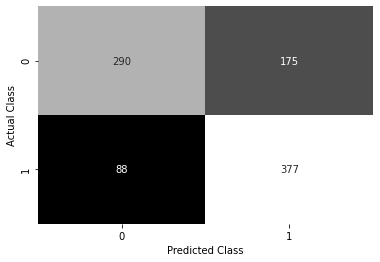

Accuracy Metrics:                0
count  98.000000
mean    0.685452
std     0.080317
min     0.494328
25%     0.690560
50%     0.724179
75%     0.732985
max     0.744776

Loss Metrics:                0
count  98.000000
mean    0.574456
std     0.059827
min     0.515219
25%     0.531076
50%     0.545839
75%     0.587900
max     0.693157

Val. Accuracy Metrics:                0
count  98.000000
mean    0.670334
std     0.076175
min     0.492243
25%     0.679743
50%     0.704057
75%     0.715245
max     0.723150

Val. Loss Metrics:                0
count  98.000000
mean    0.587330
std     0.050616
min     0.547588
25%     0.553668
50%     0.561028
75%     0.588519
max     0.693203


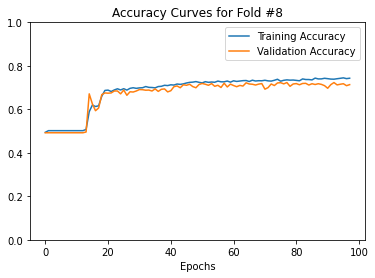

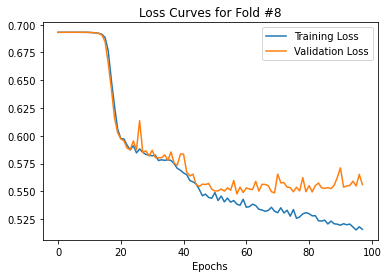

Training for Fold #9
Epoch 1/2500
105/105 [==============================] - 19s 114ms/step - loss: 0.6932 - accuracy: 0.4966 - val_loss: 0.6931 - val_accuracy: 0.4964
Epoch 2/2500
105/105 [==============================] - 10s 100ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6931 - val_accuracy: 0.4964
Epoch 3/2500
105/105 [==============================] - 10s 100ms/step - loss: 0.6931 - accuracy: 0.4958 - val_loss: 0.6931 - val_accuracy: 0.4964
Epoch 4/2500
105/105 [==============================] - 10s 98ms/step - loss: 0.6931 - accuracy: 0.5009 - val_loss: 0.6931 - val_accuracy: 0.4964
Epoch 5/2500
105/105 [==============================] - 10s 98ms/step - loss: 0.6932 - accuracy: 0.4913 - val_loss: 0.6931 - val_accuracy: 0.4964
Epoch 6/2500
105/105 [==============================] - 10s 97ms/step - loss: 0.6931 - accuracy: 0.5054 - val_loss: 0.6931 - val_accuracy: 0.4964
Epoch 7/2500
105/105 [==============================] - 10s 97ms/step - loss: 0.6931 - accuracy: 0.5

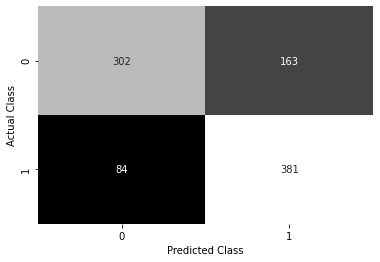

Accuracy Metrics:                 0
count  117.000000
mean     0.696063
std      0.080579
min      0.491343
25%      0.702687
50%      0.729702
75%      0.742537
max      0.766567

Loss Metrics:                 0
count  117.000000
mean     0.563982
std      0.066708
min      0.488924
25%      0.518713
50%      0.537477
75%      0.577831
max      0.693156

Val. Accuracy Metrics:                 0
count  117.000000
mean     0.677289
std      0.070847
min      0.496420
25%      0.685561
50%      0.711217
75%      0.716587
max      0.723747

Val. Loss Metrics:                 0
count  117.000000
mean     0.590415
std      0.049998
min      0.551508
25%      0.557989
50%      0.565240
75%      0.588519
max      0.693149


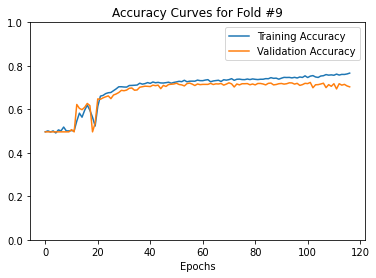

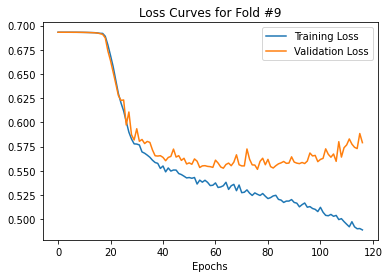

Training for Fold #10
Epoch 1/2500
105/105 [==============================] - 20s 113ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.4964
Epoch 2/2500
105/105 [==============================] - 10s 99ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.4964
Epoch 3/2500
105/105 [==============================] - 10s 100ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.4964
Epoch 4/2500
105/105 [==============================] - 10s 99ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.4964
Epoch 5/2500
105/105 [==============================] - 10s 98ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.4964
Epoch 6/2500
105/105 [==============================] - 10s 98ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.4964
Epoch 7/2500
105/105 [==============================] - 10s 97ms/step - loss: 0.6932 - accuracy: 0.4

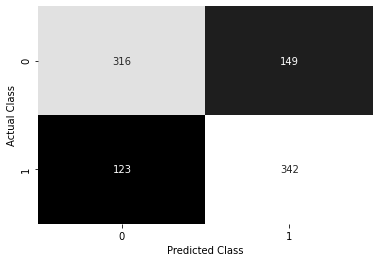

Accuracy Metrics:                 0
count  128.000000
mean     0.665880
std      0.105549
min      0.495821
25%      0.500896
50%      0.726269
75%      0.738284
max      0.776716

Loss Metrics:                 0
count  128.000000
mean     0.580986
std      0.078057
min      0.468726
25%      0.522732
50%      0.547518
75%      0.693121
max      0.693158

Val. Accuracy Metrics:                 0
count  128.000000
mean     0.648610
std      0.095719
min      0.496420
25%      0.496420
50%      0.707041
75%      0.714946
max      0.730907

Val. Loss Metrics:                 0
count  128.000000
mean     0.612026
std      0.053504
min      0.562796
25%      0.569896
50%      0.582909
75%      0.693116
max      0.693160


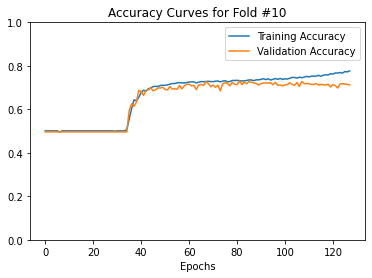

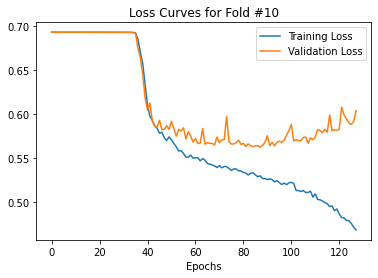

In [4]:
#Hyperparameters
epochs= 2500
batch_size= 64
validation_split= 0.2
lr = 1e-4
early_stop= keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose =1, patience=40, restore_best_weights=True)
opt= keras.optimizers.Adam(learning_rate=lr)

total_confmat = np.zeros((2,2))
fold_num=1
total_history = []
total_results = []

start = time.time()
for train, test in skfold.split(X,Y):
  X_train, X_test = X[train], X[test]
  Y_train =  to_categorical(Y[train])                                                        
  Y_test =  to_categorical(Y[test])                                                        
  
  keras.backend.clear_session()
  model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics=['accuracy'])
  model.set_weights(init_weights)
  model.reset_states()

  print(f'Training for Fold #{fold_num}')
  history = model.fit(X_train, Y_train, validation_split= validation_split, epochs =epochs, batch_size=batch_size, verbose =1, callbacks=[early_stop])
  res = model.evaluate(X_test, Y_test)

  total_history.append(history)
  total_results.append(res)

  #Prediction
  Ypred = model.predict(X_test)
  Ypred = np.round(Ypred)
  print(classification_report(Y_test,Ypred))

  #Confusion Matrix
  confmat = confusion_matrix(Y_test.argmax(axis=1),Ypred.argmax(axis=1))
  confmat_heatmap = sns.heatmap(confmat, annot=True, fmt='', cmap='gray', cbar = False)
  plt.xlabel('Predicted Class')
  plt.ylabel('Actual Class')
  plt.title('')
  plt.show()

  total_confmat+= confmat

  #Stats of Metrics
  acc = pd.DataFrame(history.history['accuracy'])
  loss  = pd.DataFrame(history.history['loss'])
  valacc = pd.DataFrame(history.history['val_accuracy'])
  valloss = pd.DataFrame(history.history['val_loss'])
  print(f'Accuracy Metrics: {acc.describe()}\n')
  print(f'Loss Metrics: {loss.describe()}\n')
  print(f'Val. Accuracy Metrics: {valacc.describe()}\n')
  print(f'Val. Loss Metrics: {valloss.describe()}')

  #Plots
  plt.figure()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend(['Training Accuracy','Validation Accuracy'])
  plt.xlabel('Epochs')
  plt.title(label=f'Accuracy Curves for Fold #{fold_num}')
  plt.ylim(0,1)
  plt.show()
  plt.figure()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['Training Loss','Validation Loss'])
  plt.xlabel('Epochs')
  plt.title(label=f'Loss Curves for Fold #{fold_num}')
  plt.show()

  fold_num+=1

end = time.time()

In [5]:
np.mean(np.array(total_results)[:,1]), np.std(np.array(total_results)[:,1])

(0.7266264736652375, 0.01022611549344565)

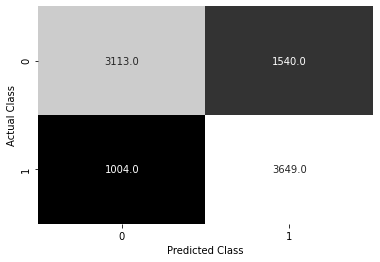

In [6]:
  confmat_heatmap = sns.heatmap(total_confmat, annot=True, fmt='', cmap='gray', cbar = False)
  plt.xlabel('Predicted Class')
  plt.ylabel('Actual Class')
  plt.title('')
  plt.show()

In [7]:
total_results

[[0.5615593791007996, 0.7185821533203125],
 [0.5181575417518616, 0.7411385774612427],
 [0.5430220365524292, 0.733619749546051],
 [0.5354599952697754, 0.7314715385437012],
 [0.561404287815094, 0.7164339423179626],
 [0.5355095267295837, 0.7325456738471985],
 [0.5415229797363281, 0.7333333492279053],
 [0.5610771179199219, 0.7172042727470398],
 [0.5537751913070679, 0.7344086170196533],
 [0.5445706844329834, 0.7075268626213074]]